# Importing required Modules and Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from nltk import pos_tag
import string, pickle, nltk
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score,KFold

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,confusion_matrix,precision_score,recall_score,roc_auc_score,classification_report,
f1_score,roc_curve,log_loss)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing and visualize the data
train= pd.read_csv('hotel_train.csv')
print('Sample of train data \n', train.head(3))
test= pd.read_csv('hotel_test.csv')
print('\n\n Sample of train data \n',test.head(3))

Sample of train data 
    User_ID                                        Description  \
0  id10326  The room was kind of clean but had a VERY stro...   
1  id10327  I stayed at the Crown Plaza April -- - April -...   
2  id10328  I booked this hotel through Hotwire at the low...   

        Browser_Used Device_Used Is_Response  
0               Edge      Mobile   not happy  
1  Internet Explorer      Mobile   not happy  
2            Mozilla      Tablet   not happy  


 Sample of train data 
    User_ID                                        Description  \
0  id80132  Looking for a motel in close proximity to TV t...   
1  id80133  Walking distance to Madison Square Garden and ...   
2  id80134  Visited Seattle on business. Spent - nights in...   

       Browser_Used Device_Used  
0           Firefox      Mobile  
1  InternetExplorer     Desktop  
2                IE      Tablet  


In [3]:
#checking the shape of data
print('Shape of train data set',train.shape)
print('Shape of test data set',test.shape)

Shape of train data set (38932, 5)
Shape of test data set (29404, 4)


In [4]:
#checking data type
print('Data type of train data set\n',train.dtypes)
print('\nData type of test data set\n',test.dtypes)

Data type of train data set
 User_ID         object
Description     object
Browser_Used    object
Device_Used     object
Is_Response     object
dtype: object

Data type of test data set
 User_ID         object
Description     object
Browser_Used    object
Device_Used     object
dtype: object


In [5]:
#looking for missing value
print('missing value of train data set\n',train.isnull().sum())
print('\n missing value of test data set\n',test.isnull().sum())

missing value of train data set
 User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64

 missing value of test data set
 User_ID         0
Description     0
Browser_Used    0
Device_Used     0
dtype: int64


In [6]:
#dropping the  columns
train.drop(['User_ID', 'Browser_Used', 'Device_Used'],axis=1,inplace=True)
test.drop(['User_ID','Browser_Used','Device_Used'],axis=1,inplace=True)

In [7]:
#visualize data again
print('Sample of train data \n', train.head(3))
print('\n\n Sample of train data \n',test.head(3))

Sample of train data 
                                          Description Is_Response
0  The room was kind of clean but had a VERY stro...   not happy
1  I stayed at the Crown Plaza April -- - April -...   not happy
2  I booked this hotel through Hotwire at the low...   not happy


 Sample of train data 
                                          Description
0  Looking for a motel in close proximity to TV t...
1  Walking distance to Madison Square Garden and ...
2  Visited Seattle on business. Spent - nights in...


# EDA of Train data

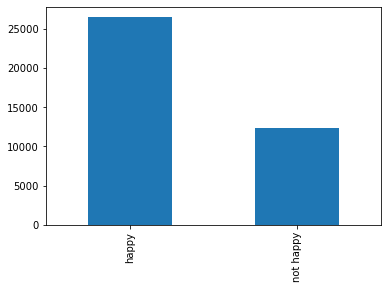

In [8]:
#Checking if training data is balanced or not
train['Is_Response'].value_counts().plot.bar()

In [9]:
# checking count 
print ('happy and not happy counts','\n',train.Is_Response.value_counts())

happy and not happy counts 
 happy        26521
not happy    12411
Name: Is_Response, dtype: int64


In [10]:
#checking the normalized counts
train['Is_Response'].value_counts(normalize=True)

happy        0.681213
not happy    0.318787
Name: Is_Response, dtype: float64

In [11]:
# adding length of the messages in training data
train['review_length'] = train['Description'].apply(len)
train.head(3)

,Description,Is_Response,review_length
0,The room was kind of clean but had a VERY stro...,not happy,248
1,I stayed at the Crown Plaza April -- - April -...,not happy,1077
2,I booked this hotel through Hotwire at the low...,not happy,1327


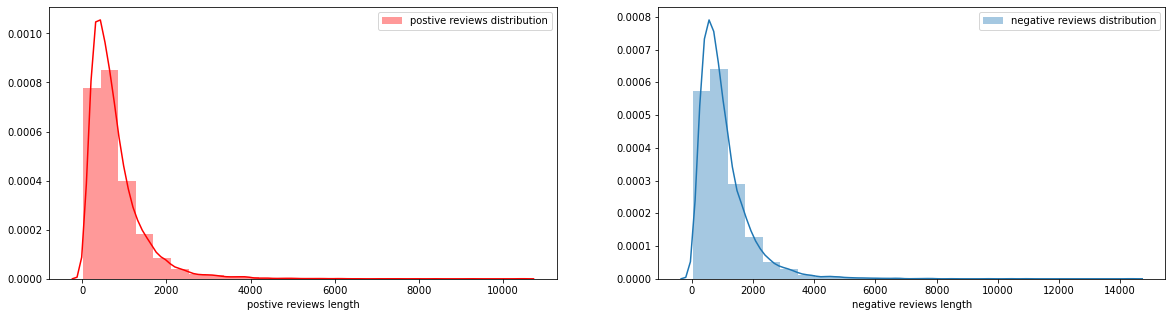

In [12]:
# checking distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (20,5))

sns.distplot(train[train['Is_Response']=='happy']['review_length'],bins=25,ax=ax[0],label='postive reviews distribution',color='r')

ax[0].set_xlabel('postive reviews length')
ax[0].legend()

sns.distplot(train[train['Is_Response']=='not happy']['review_length'],bins=25,ax=ax[1],label='negative reviews distribution')
ax[1].set_xlabel('negative reviews length')
ax[1].legend()

plt.show()

# DATA CLEANING

In [13]:
# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
# Let us create a function for cleaning the text data
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [15]:
# clean text data
train["clean_desc"] = train["Description"].apply(lambda x: clean_text(x))

In [16]:
#adding length of reviews after cleaning the data
train['clean_review_length'] = train['clean_desc'].apply(len)

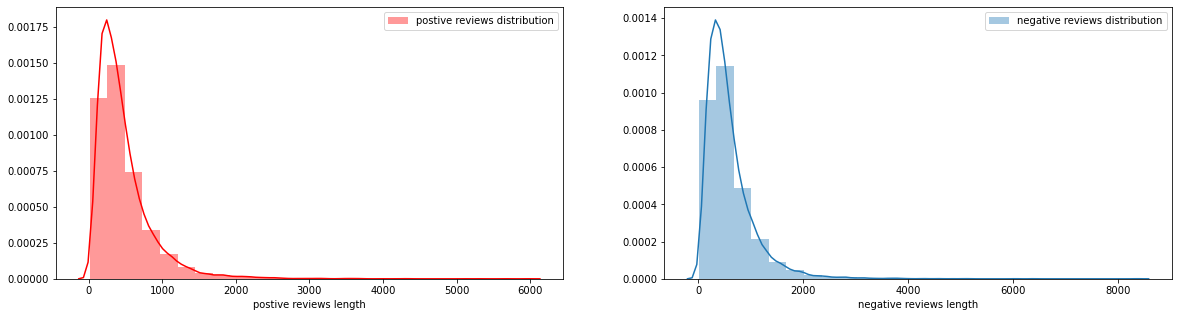

In [17]:
# review distribution after cleaning
f,ax = plt.subplots(1,2,figsize = (20,5))

sns.distplot(train[train['Is_Response']=='happy']['clean_review_length'],bins=25,ax=ax[0],label='postive reviews distribution',color='r')

ax[0].set_xlabel('postive reviews length')
ax[0].legend()

sns.distplot(train[train['Is_Response']=='not happy']['clean_review_length'],bins=25,ax=ax[1],label='negative reviews distribution')
ax[1].set_xlabel('negative reviews length')
ax[1].legend()

plt.show()

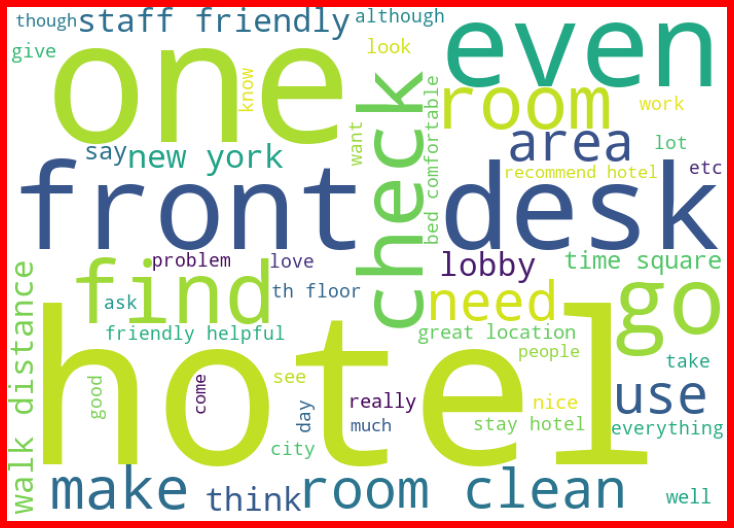

In [18]:
#frequent words used in postive reviews in training data with word cloud
happy = train['clean_desc'][train['Is_Response']=='happy']

happy_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(happy))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(happy_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

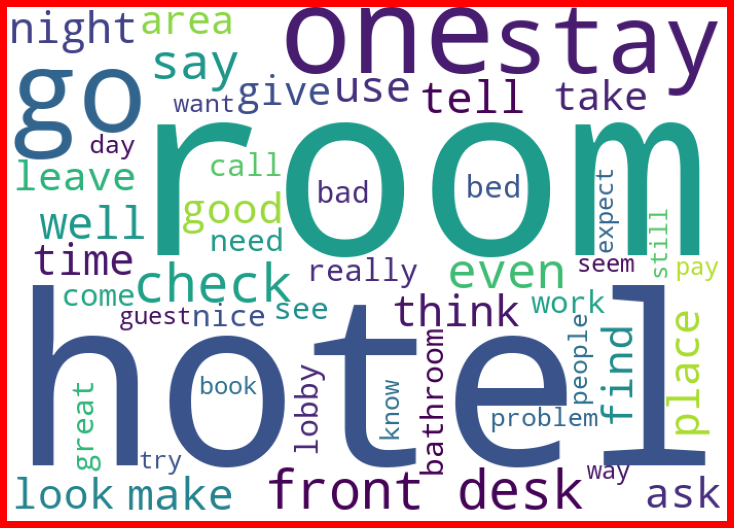

In [19]:
# frequent words used in negative reviews in training data with word cloud
not_happy = train['clean_desc'][train['Is_Response']=='not happy']

not_happy_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(not_happy))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(not_happy_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [20]:
#Label coding Is_Response to 0 and 1
train['Is_Response'].replace({'happy':0,'not happy':1},inplace=True)

In [21]:
#Lets  check the training data
train.head()

,Description,Is_Response,review_length,clean_desc,clean_review_length
0,The room was kind of clean but had a VERY stro...,1,248,room kind clean strong smell dog generally ave...,134
1,I stayed at the Crown Plaza April -- - April -...,1,1077,stay crown plaza april april staff friendly at...,621
2,I booked this hotel through Hotwire at the low...,1,1327,booked hotel hotwire low price could find got ...,774
3,Stayed here with husband and sons on the way t...,0,502,stayed husband son way alaska cruise love hote...,320
4,My girlfriends and I stayed here to celebrate ...,1,1613,girlfriend stay celebrate th birthday plan wee...,903


In [22]:
#Converting training text into vectors using TF-IDF
tf_vec = TfidfVectorizer()
feature = tf_vec.fit_transform(train['clean_desc'])
target = train['Is_Response']

# Checking performance of Different Models on training data

In [36]:
#creating models array with all the model
Models=[('LR', LogisticRegression()), ('KNN', KNeighborsClassifier()),
('CART', DecisionTreeClassifier(random_state=5)),('NB', MultinomialNB()),
('SVM', SVC())]

In [37]:
# loop to find out the cross_val_score of all the model in models array
Cross_val_score_array=[]
Standard_Deviation=[]
for name, model in Models:
    kf=KFold(n_splits=10,random_state=5)
    cscore=cross_val_score(model,feature, target, cv=kf, scoring='f1')
    Cross_val_score_array.append(cscore.mean())
    Standard_Deviation.append(cscore.std())

In [39]:
# comparing the performances of all the model on crossval basis
model_cross_val_performance = pd.DataFrame({'Model': Model_array,'Cross val Acuracy': Cross_val_score_array,
                                            'Standard Deviation': Standard_Deviation})
model_cross_val_performance.sort_values(by='Cross val Acuracy', ascending=False)

,ModelName,mean_f1_score
4,SVM,0.806073
0,LR,0.803109
1,KNN,0.605508
2,CART,0.594502
3,NB,0.574292


### Conclusion
On basis of Cross val Acuracy SVM  model is performing the best closly follow by LogisticRegression

In [26]:
#Lets also calculate the  k-fold cross validation accuracy of Logistic regression
LR = LogisticRegression()
kf=KFold(n_splits=10,random_state=5)
cv_results = cross_val_score(LR, feature, target, cv=kf, scoring='accuracy')
print('mean kfold cross val accuracy of logistic regression = ', cv_results.mean())

mean kfold cross val accuracy of logistic regression =  0.8827444555311172


# Cleaning test data for training of model

In [27]:
test.head()

,Description
0,Looking for a motel in close proximity to TV t...
1,Walking distance to Madison Square Garden and ...
2,Visited Seattle on business. Spent - nights in...
3,This hotel location is excellent and the rooms...
4,This hotel is awesome I love the service Antho...


In [28]:
test["cleaned_desc"] = test["Description"].apply(lambda x: clean_text(x))

In [29]:
#Let us see the test data again
test.head()

,Description,cleaned_desc
0,Looking for a motel in close proximity to TV t...,look motel close proximity tv tap dr phil show...
1,Walking distance to Madison Square Garden and ...,walk distance madison square garden penn subwa...
2,Visited Seattle on business. Spent - nights in...,visit seattle business spend night vintage par...
3,This hotel location is excellent and the rooms...,hotel location excellent room clean suite one ...
4,This hotel is awesome I love the service Antho...,hotel awesome love service anthony really grea...


In [30]:
#convert text data into vectors using TF-IDF
X_test = tf_vec.transform(test["cleaned_desc"])

# training model and predecting sentiments

In [31]:
#final classification model
lr=LogisticRegression()

lr.fit(feature,target)
pred=lr.predict(X_test)

In [32]:
#checking sample of the test prediction
test['Description'][0]

"Looking for a motel in close proximity to TV taping of a Dr. Phil show, we chose the Dunes on Sunset Blvd in West Hollywood. Although the property displayed the AAA emblem, it certainly left a lot to be desired. There were chips & scrapes on the bottom of the door frame in the bathroom and the lotion containers were half full--apparently not replaced by housekeeping. We needed an early wakeup call, but couldn't use the clock radio alarm as there wasn't a radio in the room. There was no TV channel listing on the remote, or on the TV menu making viewing a chore.The TV remote had to be returned when checking-out. This place served its purpose, but not a place to revisit."

In [33]:
#from above we can determine its a negative sentiment, now checking what our model predicted
pred[0]

1

In [34]:
predicted_sentiments = pd.DataFrame(pred, columns=['Sentiment'])

In [35]:
predicted_sentiments['Description'] = test['Description']
predicted_sentiments.head()

,Sentiment,Description
0,1,Looking for a motel in close proximity to TV t...
1,0,Walking distance to Madison Square Garden and ...
2,0,Visited Seattle on business. Spent - nights in...
3,1,This hotel location is excellent and the rooms...
4,0,This hotel is awesome I love the service Antho...


In [36]:
#Lets us save this data a csv file
predicted_sentiments.to_csv('hotel_sentiments.csv')

In [38]:
# saving model 
save = open('saved_model.sav','wb')
pickle.dump(lr,save)
save.close()